In [1]:
# Goal: Try out fitting multiple datasets with offsets at the same time
# Testcase: ZTF and GROND datasets

# Global Config:
band = 'r'

In [2]:
# import stuff we need
import os,sys
import numpy as np
import matplotlib.pyplot as plt
import astropy.table as table

from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import corner

try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
import snelib19odp.const as const
import snelib19odp.lc.interpolate as interpolate

import gp3.ztf.ingest as ingest

In [3]:
# load ZTF dataset
# load data
ztflc = table.Table.read('../data/ztflc_forcefit.h5')
ztflc['mag'] = -2.5*np.log10(ztflc['ampl']) + ztflc['magzp']
ztflc['mag_err'] = ztflc['ampl.err']/ztflc['ampl']*1.087 + ztflc['magzprms']
ztflc['phase'] = ztflc['obsmjd'] - const.sne_peak_mjd['g']

# plot ztflc
scalezp = 0
f0coef = 3631e6 * 10 ** (-(ztflc["magzp"] - scalezp) / 2.5)
ztflc['flux_uJy'] = f0coef*ztflc['ampl']
ztflc['flux_uJy.err'] = f0coef*ztflc['ampl.err']
ztflc['mjd'] = ztflc['obsmjd']

idx = ztflc['phase'] > -20
idx = np.logical_and(idx, ztflc['filter'] == ('ZTF_%s' % band))
ztflc = ztflc[idx]
ztflc.sort('obsmjd')
ztflc

<ipython-input-3-3a473e7dfc82>:4: RuntimeWarning: invalid value encountered in log10
  ztflc['mag'] = -2.5*np.log10(ztflc['ampl']) + ztflc['magzp']


<Table length=85>
      sigma             sigma.err      ...    flux_uJy.err         mjd     
     float64             float64       ...      float64          float64   
------------------ ------------------- ... ------------------ -------------
 7.919573152139289 0.21979808811474116 ... 3.0609929135865444 58716.3888079
 8.414544473036816 0.24039892974057492 ... 3.2499315266613302 58716.3916319
 8.159337734764366  0.2261023659945145 ... 3.0760420019798764 58716.3920833
 6.746604250147952 0.18966269167866504 ...  3.105143689337348 58717.3283796
 6.586886722562901  0.1840384771770431 ...  4.556307504093203 58718.3720602
 6.098808044445885 0.17537347355769434 ... 2.6965343857828796 58719.3820486
 6.174071583719002  0.1685539963985467 ...  2.617995550622273    58719.3825
 5.870221384656331 0.15981106383242252 ... 2.3361079415932258 58720.3941782
 6.028424015483062 0.17076618689475798 ... 2.3617735358664502 58720.3946296
5.9958875552834465 0.16453856477410347 ...  4.323238827568566  58721.314213
               ...                 ... ...                ...           ...
 12.57069478405603   0.357744279725933 ...  6.211055891190244 58873.0930787
 11.17162574053698 0.31134426347099214 ...  5.352111289344568 59014.4816551
 5.061686147881116 0.14497298106823747 ...  1.921516734882645 59018.4656134
  6.36329354404041  0.1774248241769233 ... 2.4727168506276405 59026.4743981
 6.790269111165908 0.19755125562814874 ... 3.3224693920764747 59030.4668634
13.380180036161295 0.37292168647668056 ...  5.306004638971929 59036.3820486
 11.16743042466407  0.3051480017291456 ...  5.580622812030493 59039.4568403
 7.608362038731256 0.21204732924074718 ... 2.8037059445626853 59042.4632523
 5.380505973919246  0.1545084515835955 ...  2.261786531365851 59045.3621759
 4.998202581685263 0.13419440737214583 ...  1.883218187876832 59046.4225116

In [4]:
# load marshal dataset
marshal = ingest.ingest_growth_marshall_data('../data/marshal_raw_lc_v2.csv')
marshal.reset_index(inplace=True)
shal = table.Table.from_pandas(marshal)
#marshal['mjd'] = marshal['jdobs'] - 2400000.5
marshal['mag_err'] = marshal['magerr']
idx = marshal['mag_err'] < 99.0
idx = np.logical_and(idx, marshal['filter'] == band)
marshal = marshal[idx]
marshal

telescope instrument filter         mjd phot_type         date  \
34        P48        ZTF      r  58716.3888    IS+PSF  2019 Aug 21   
35        P48        ZTF      r  58716.3888    IS+PSF  2019 Aug 21   
36        P48        ZTF      r  58716.3916    IS+PSF  2019 Aug 21   
37        P48        ZTF      r  58716.3920    IS+PSF  2019 Aug 21   
38        P60       SEDM      r  58717.1608    IS+PSF  2019 Aug 22   
..        ...        ...    ...         ...       ...          ...   
311       NaN        NaN      r  59046.0593    IS+PSF  2020 Jul 16   
312       NaN        NaN      r  59046.0593    IS+PSF  2020 Jul 16   
319       NaN        NaN      r  59052.1213    IS+PSF  2020 Jul 22   
320       NaN        NaN      r  59052.1213    IS+PSF  2020 Jul 22   
326       NaN        NaN      r  59094.6032    IS+PSF  2020 Sep 02   

            jdobs  mag_abs    mag  magerr  mag_limiting programid  \
34   2.458717e+06   -15.12  18.80    0.09         20.25         1   
35   2.458717e+06   -15.12  18.80    0.09         20.25         1   
36   2.458717e+06   -15.13  18.79    0.08         20.26         2   
37   2.458717e+06   -15.25  18.67    0.07         20.33         3   
38   2.458718e+06   -15.17  18.74    0.19           NaN      None   
..            ...      ...    ...     ...           ...       ...   
311  2.459047e+06   -12.91  21.01    0.30         21.21      None   
312  2.459047e+06   -12.91  21.01    0.30         21.21      None   
319  2.459053e+06   -12.40  21.52    0.14         23.53      None   
320  2.459053e+06   -12.40  21.52    0.14         23.53      None   
326  2.459095e+06   -14.98  18.94    0.23         19.41      None   

                       reducedby refsys  issub  isdiffpos  mag_err  
34                          None   None   True       True     0.09  
35                          None   None   True       True     0.09  
36                          None   None   True       True     0.08  
37                          None   None   True       True     0.07  
38   Fremling Automated Pipeline   SDSS   True       True     0.19  
..                           ...    ...    ...        ...      ...  
311                        K. De    PS1   True       True     0.30  
312                        K. De    PS1   True       True     0.30  
319   Taggart Automated Pipeline    PS1   True       True     0.14  
320   Taggart Automated Pipeline    PS1   True       True     0.14  
326                        K. De    PS1   True       True     0.23  

[135 rows x 17 columns]

In [5]:
p48 = marshal[marshal['telescope'] == 'P48']
p60 = marshal[marshal['telescope'] == 'P60']

In [6]:
# load GROND dataset
grond = table.Table.read('../data/grond_lc/v4.fits')
grond['mag'] = grond['mag_%s' % band]
grond['mag_err'] = grond['magerr_%s' % band]

grond.sort('mjd')
idx = ~np.isnan(grond['mag'])
grond = grond[idx]
grond

<Table length=8>
       mjd              mag_g        ...        mag               mag_err       
     float64           float64       ...      float64             float64       
----------------- ------------------ ... ------------------ --------------------
 58764.1901355999 18.898626500001548 ... 17.682896101306607  0.14814884504101872
58772.07589106129 19.565166333334886 ...  18.13078466666699   0.4325273426640451
58774.04200655782 18.961489555556803 ... 17.833338928572037  0.01249209950569336
58778.11519076466   18.8214155045909 ... 17.846443538565516 0.009743920951678245
58783.09287482079 19.011296671202977 ... 17.940389258979298 0.009152986016024052
58789.05341837661  18.95522853103948 ... 18.101440507969837 0.008873691871898917
58794.05187395877  19.02260613698111 ... 18.104944000000618 0.008333753478468807
58814.05056632643  19.27459314445816 ... 18.625340041117656   0.1373889330401826

In [7]:
gp, results, (t,y,yerr), offset_matrix = interpolate.sample_model_multi_ds([ztflc, p60, grond], max_ds_offset=0.5, prior_t0=const.sne_peak_mjd['g'])

11132it [07:43, 20.38it/s, batch: 0 | bound: 146 | nc: 25 | ncall: 253110 | eff(%):  4.389 | loglstar:   -inf < 123.568 <    inf | logz: 101.503 +/-  0.284 | dlogz: 12.445 >  0.010]  /home/welterde/.local/lib/python3.9/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
/home/welterde/.local/lib/python3.9/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
11201it [07:50, 20.66it/s, batch: 0 | bound: 148 | nc: 25 | ncall: 256822 | eff(%):  4.353 | loglstar:   -inf < 123.814 <    inf | logz: 101.618 +/-  0.285 | dlogz: 12.193 >  0.010]  /home/welterde/.local/lib/python3.9/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficie

13076it [10:29, 22.76it/s, batch: 0 | bound: 191 | nc: 25 | ncall: 336680 | eff(%):  3.878 | loglstar:   -inf < 129.237 <    inf | logz: 103.981 +/-  0.302 | dlogz:  8.305 >  0.010]  /home/welterde/.local/lib/python3.9/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/home/welterde/.local/lib/python3.9/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
13347it [10:50, 23.21it/s, batch: 0 | bound: 196 | nc: 25 | ncall: 348118 | eff(%):  3.829 | loglstar:   -inf < 129.988 <    inf | logz: 104.205 +/-  0.304 | dlogz:  7.539 >  0.010]/home/welterde/.local/lib/python3.9/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient

16737it [17:50, 19.97it/s, batch: 0 | bound: 273 | nc: 25 | ncall: 565421 | eff(%):  2.957 | loglstar:   -inf < 139.677 <    inf | logz: 107.127 +/-  0.342 | dlogz:  5.349 >  0.010]  /home/welterde/.local/lib/python3.9/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/home/welterde/.local/lib/python3.9/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
16799it [18:04, 20.33it/s, batch: 0 | bound: 275 | nc: 25 | ncall: 572300 | eff(%):  2.933 | loglstar:   -inf < 139.839 <    inf | logz: 107.177 +/-  0.343 | dlogz:  5.176 >  0.010]  /home/welterde/.local/lib/python3.9/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficie

/home/welterde/.local/lib/python3.9/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
18122it [21:57, 22.02it/s, batch: 0 | bound: 309 | nc: 25 | ncall: 693785 | eff(%):  2.610 | loglstar:   -inf < 143.040 <    inf | logz: 108.072 +/-  0.355 | dlogz:  4.163 >  0.010]  /home/welterde/.local/lib/python3.9/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/home/welterde/.local/lib/python3.9/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
18389it [22:22, 20.21it/s, batch: 0 | bound: 314 | nc: 25 | ncall: 707389 | eff(%):  2.59

19716it [26:23, 20.17it/s, batch: 0 | bound: 347 | nc: 25 | ncall: 835532 | eff(%):  2.358 | loglstar:   -inf < 146.320 <    inf | logz: 108.773 +/-  0.365 | dlogz:  2.489 >  0.010]  /home/welterde/.local/lib/python3.9/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/home/welterde/.local/lib/python3.9/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
19904it [26:49, 25.82it/s, batch: 0 | bound: 351 | nc: 25 | ncall: 849292 | eff(%):  2.342 | loglstar:   -inf < 146.702 <    inf | logz: 108.831 +/-  0.366 | dlogz:  2.099 >  0.010]/home/welterde/.local/lib/python3.9/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient

23457it [37:42, 20.62it/s, batch: 0 | bound: 430 | nc: 25 | ncall: 1187028 | eff(%):  1.975 | loglstar:   -inf < 151.050 <    inf | logz: 109.240 +/-  0.375 | dlogz:  0.028 >  0.010]   /home/welterde/.local/lib/python3.9/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/home/welterde/.local/lib/python3.9/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
23884it [38:23, 24.30it/s, batch: 0 | bound: 437 | nc: 25 | ncall: 1209315 | eff(%):  1.974 | loglstar:   -inf < 151.325 <    inf | logz: 109.244 +/-  0.375 | dlogz:  0.015 >  0.010]   /home/welterde/.local/lib/python3.9/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely ineff

In [8]:
samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
mean, cov = dyfunc.mean_and_cov(samples, weights)
samples = dyfunc.resample_equal(samples, weights)

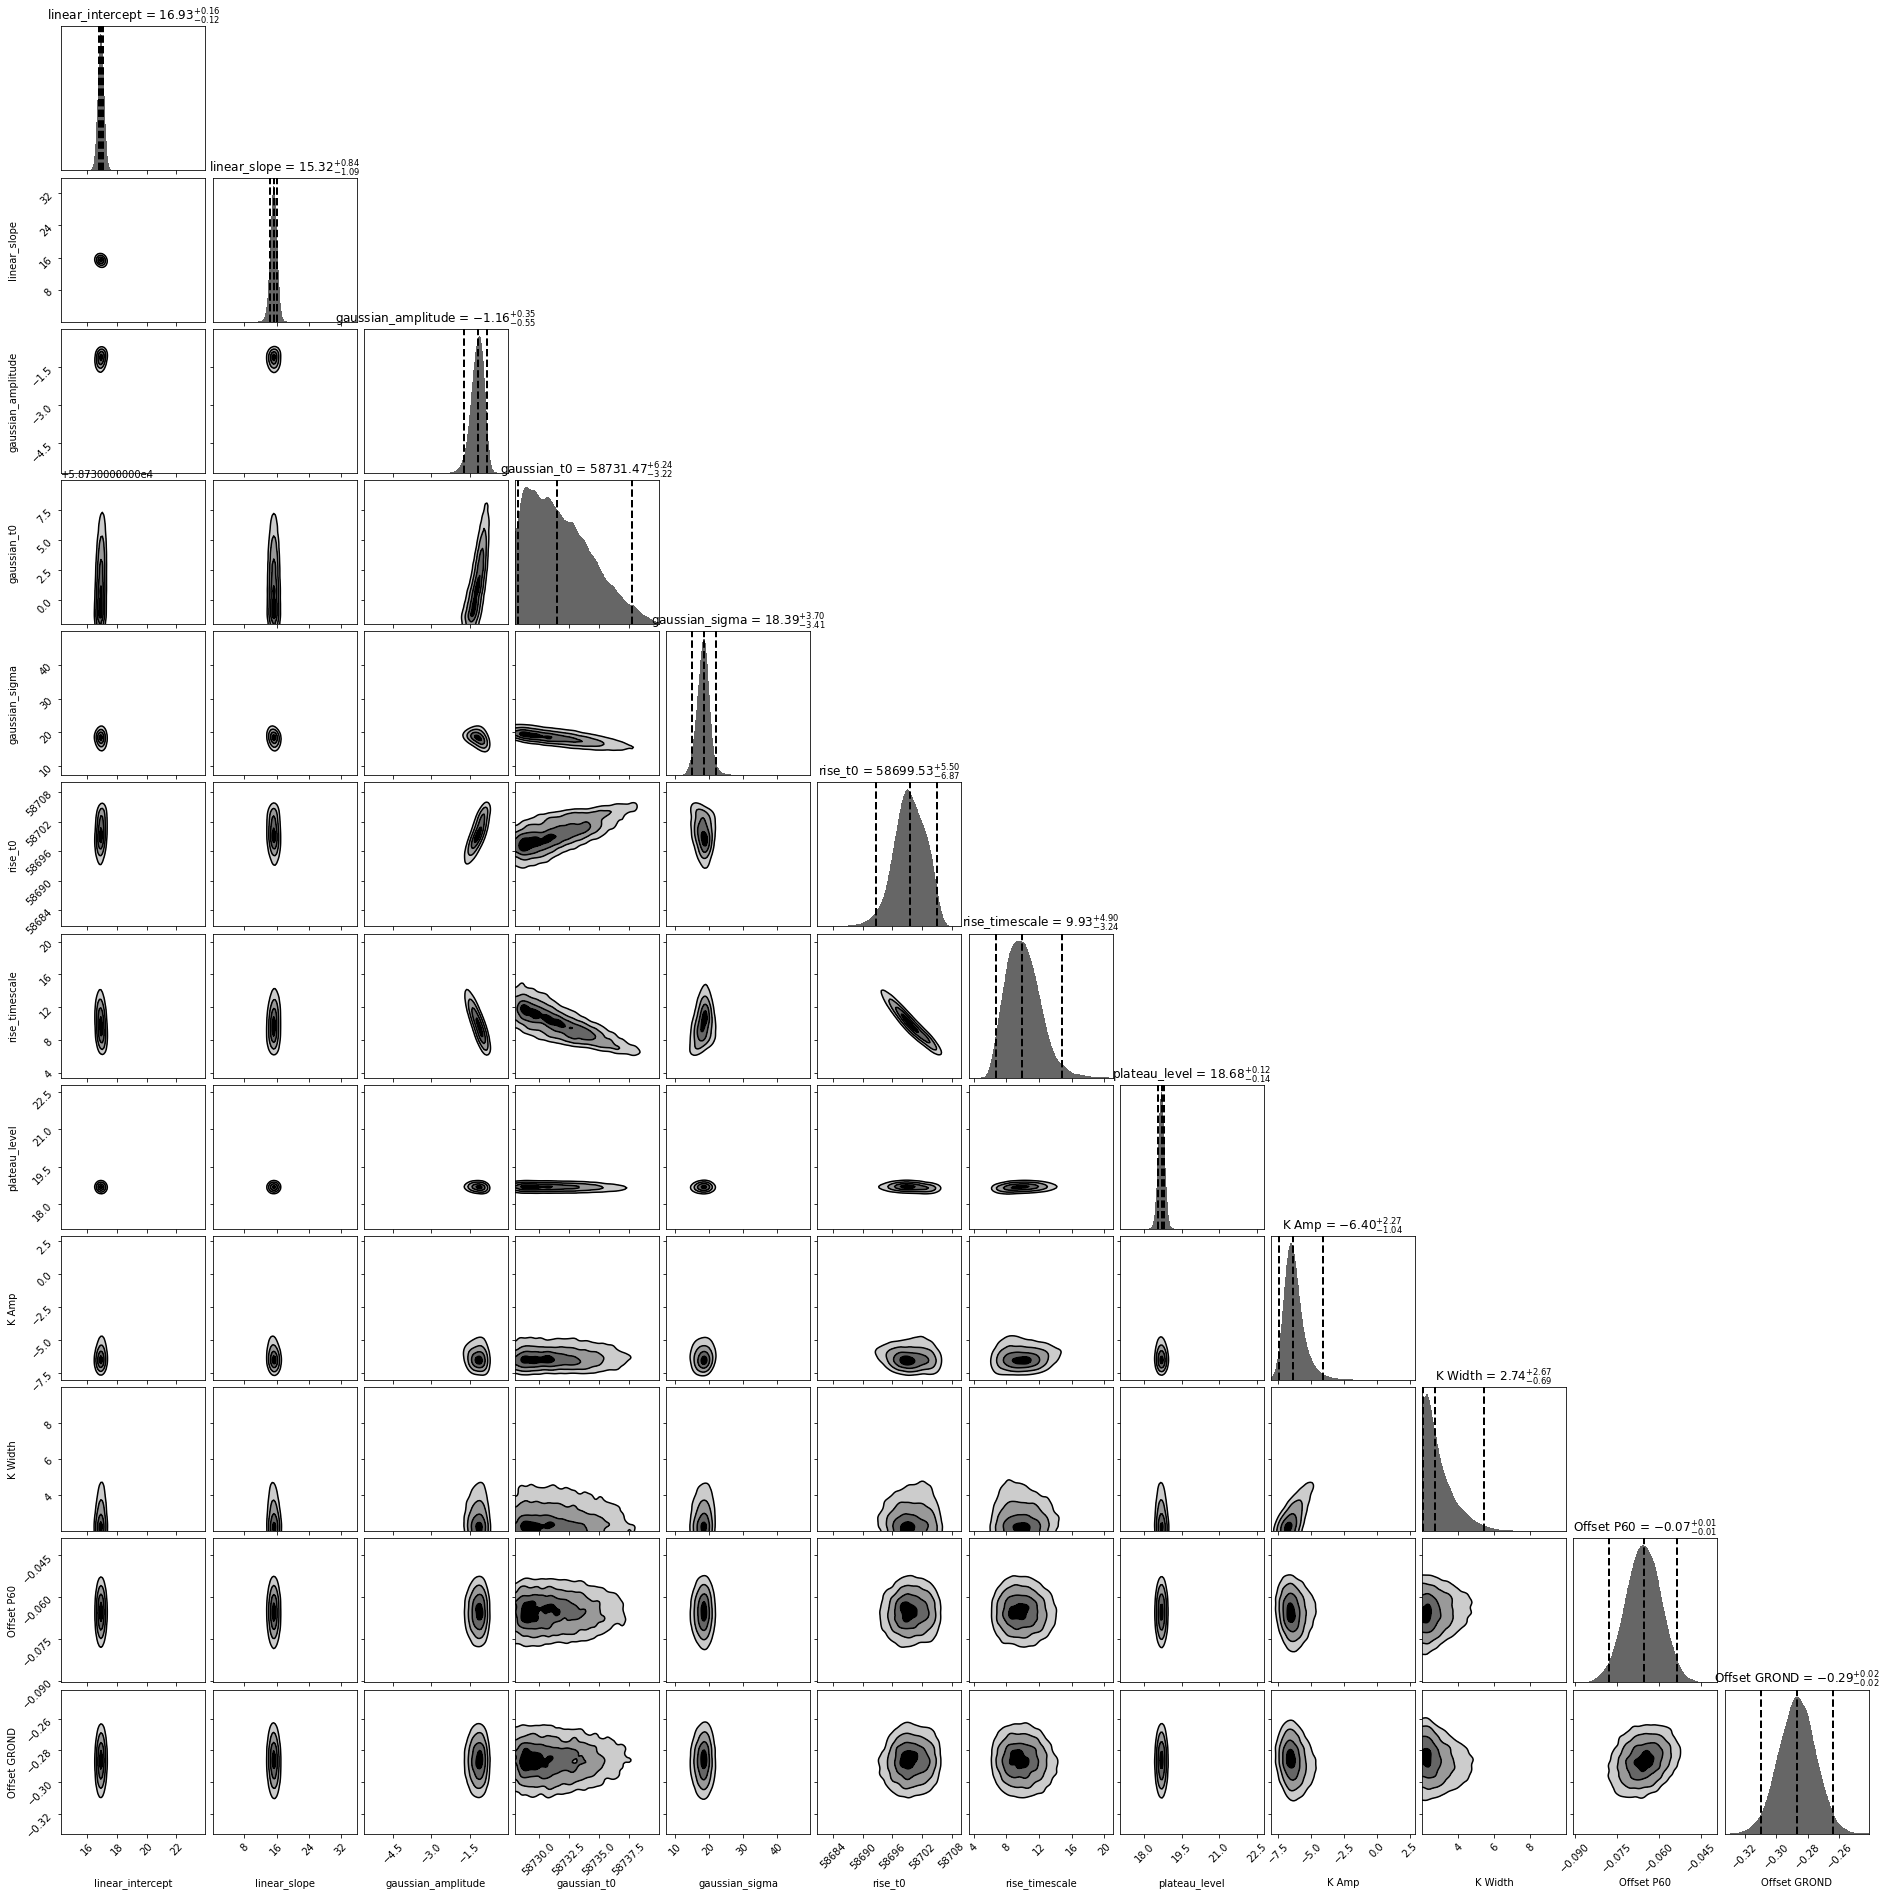

In [9]:
fg, ax = dyplot.cornerplot(results, show_titles=True, labels=interpolate.ModifiedContardo.parameter_names+('K Amp', 'K Width', 'Offset P60', 'Offset GROND',))

In [10]:
p60

telescope instrument filter         mjd phot_type         date  \
38        P60       SEDM      r  58717.1608    IS+PSF  2019 Aug 22   
48        P60       SEDM      r  58718.4546    IS+PSF  2019 Aug 23   
60        P60       SEDM      r  58723.1706    IS+PSF  2019 Aug 28   
65        P60       SEDM      r  58726.1629    IS+PSF  2019 Aug 31   
70        P60       SEDM      r  58727.2052    IS+PSF  2019 Sep 01   
71        P60       SEDM      r  58727.2272    IS+PSF  2019 Sep 01   
88        P60       SEDM      r  58736.3047    IS+PSF  2019 Sep 10   
89        P60       SEDM      r  58736.3268    IS+PSF  2019 Sep 10   
109       P60       SEDM      r  58743.3219    IS+PSF  2019 Sep 17   
110       P60       SEDM      r  58743.3440    IS+PSF  2019 Sep 17   
129       P60       SEDM      r  58749.1165    IS+PSF  2019 Sep 23   
130       P60       SEDM      r  58749.1385    IS+PSF  2019 Sep 23   
147       P60       SEDM      r  58754.2467    IS+PSF  2019 Sep 28   
148       P60       SEDM      r  58754.2686    IS+PSF  2019 Sep 28   
165       P60       SEDM      r  58763.2321    IS+PSF  2019 Oct 07   
176       P60       SEDM      r  58769.2953    IS+PSF  2019 Oct 13   
177       P60       SEDM      r  58769.3173    IS+PSF  2019 Oct 13   
181       P60       SEDM      r  58769.3241    IS+PSF  2019 Oct 13   
182       P60       SEDM      r  58769.3461    IS+PSF  2019 Oct 13   
188       P60       SEDM      r  58770.4022    IS+PSF  2019 Oct 14   
202       P60       SEDM      r  58776.2398    IS+PSF  2019 Oct 20   
203       P60       SEDM      r  58776.2669    IS+PSF  2019 Oct 20   
230       P60       SEDM      r  58791.0842    IS+PSF  2019 Nov 04   
232       P60       SEDM      r  58791.1114    IS+PSF  2019 Nov 04   
261       P60       SEDM      r  58811.2580    IS+PSF  2019 Nov 24   
286       P60       SEDM      r  58852.1392    IS+PSF  2020 Jan 04   
287       P60       SEDM      r  58852.1666    IS+PSF  2020 Jan 04   
295       P60       SEDM      r  58871.1672    IS+PSF  2020 Jan 23   

            jdobs  mag_abs    mag  magerr  mag_limiting programid  \
38   2.458718e+06   -15.17  18.74    0.19           NaN      None   
48   2.458719e+06   -15.31  18.61    0.03           NaN      None   
60   2.458724e+06   -16.54  17.38    0.02           NaN      None   
65   2.458727e+06   -16.98  16.94    0.02           NaN      None   
70   2.458728e+06   -17.14  16.78    0.01           NaN      None   
71   2.458728e+06   -17.09  16.83    0.01           NaN      None   
88   2.458737e+06   -17.53  16.39    0.02           NaN      None   
89   2.458737e+06   -17.54  16.37    0.01           NaN      None   
109  2.458744e+06   -17.48  16.43    0.01           NaN      None   
110  2.458744e+06   -17.54  16.38    0.01           NaN      None   
129  2.458750e+06   -17.29  16.63    0.02           NaN      None   
130  2.458750e+06   -17.23  16.69    0.01           NaN      None   
147  2.458755e+06   -17.07  16.85    0.01           NaN      None   
148  2.458755e+06   -17.01  16.91    0.01           NaN      None   
165  2.458764e+06   -16.68  17.24    0.02           NaN      None   
176  2.458770e+06   -16.43  17.49    0.04           NaN      None   
177  2.458770e+06   -16.39  17.53    0.31           NaN      None   
181  2.458770e+06   -16.61  17.31    0.08           NaN      None   
182  2.458770e+06   -16.41  17.51    0.04           NaN      None   
188  2.458771e+06   -16.48  17.43    0.05           NaN      None   
202  2.458777e+06   -16.38  17.54    0.02           NaN      None   
203  2.458777e+06   -16.29  17.63    0.01           NaN      None   
230  2.458792e+06   -16.02  17.89    0.03           NaN      None   
232  2.458792e+06   -16.05  17.87    0.02           NaN      None   
261  2.458812e+06   -15.77  18.15    0.03           NaN      None   
286  2.458853e+06   -15.12  18.80    0.04           NaN      None   
287  2.458853e+06   -15.13  18.79    0.02           NaN      None   
295  2.458872e+06   -14.96  18.96    0.16

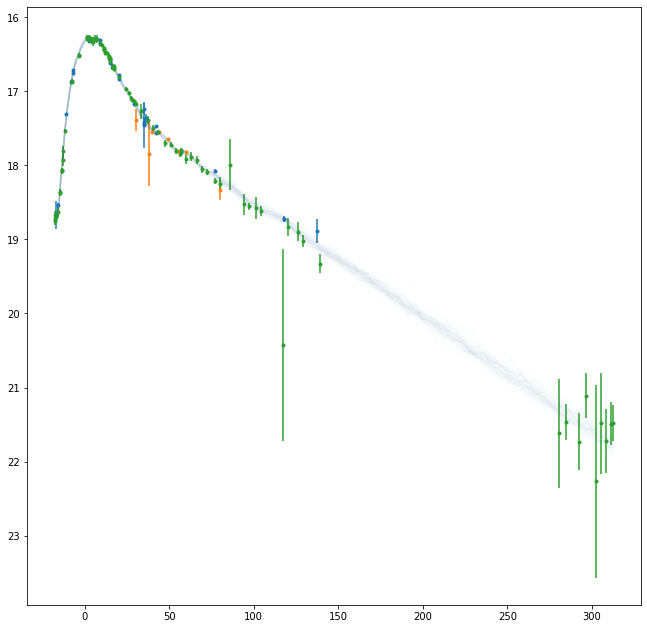

In [36]:
plt.figure(figsize=(11,11))
#plt.xlim((-10,100))
#plt.ylim((16,17))
plt.errorbar(p60['mjd'] - const.sne_peak_mjd['g'], p60['mag']-0.07, yerr=p60['mag_err'], ls='', fmt='.')
plt.errorbar(grond['mjd'] - const.sne_peak_mjd['g'], grond['mag']-0.29, yerr=grond['mag_err'], ls='', fmt='.')
plt.errorbar(ztflc['mjd'] - const.sne_peak_mjd['g'], ztflc['mag'], yerr=ztflc['mag_err'], ls='', fmt='.')

t_min = t.min()
t_max = t.max()
t_grid = np.linspace(t_min, t_max, 500)

for s in samples[np.random.randint(len(samples), size=50)]:
    master_offsets = s[len(gp.get_parameter_vector()):]
    offsets = offset_matrix.dot(master_offsets)
    gp.set_parameter_vector(s[0:len(gp.get_parameter_vector())])
    mu = gp.sample_conditional(y+offsets, t_grid)
    plt.plot(t_grid - const.sne_peak_mjd['g'], mu, color="#4682b4", alpha=0.01)

plt.gca().invert_yaxis()

In [12]:
s[len(gp.get_parameter_vector()):]

array([-0.06591869, -0.28827134])

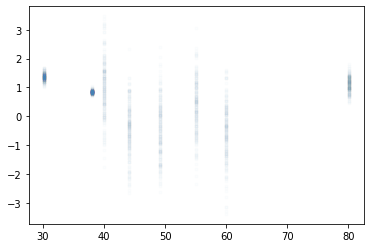

In [13]:
# diagnostics
ds = grond

for s in samples[np.random.randint(len(samples), size=200)]:
    master_offsets = s[len(gp.get_parameter_vector()):]
    offsets = offset_matrix.dot(master_offsets)
    gp.set_parameter_vector(s[0:len(gp.get_parameter_vector())])
    mu = gp.sample_conditional(y+offsets, ds['mjd'])
    diff = ds['mag']+master_offsets[1] - mu
    plt.errorbar(ds['mjd'] - const.sne_peak_mjd['g'], diff/ds['mag_err'], color="#4682b4", alpha=0.01, ls='', fmt='.')#, yerr=ds['mag_err'])

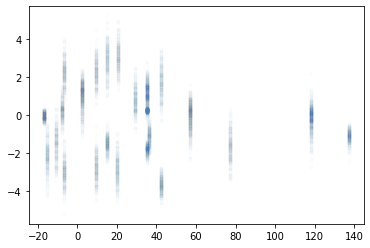

In [14]:
# diagnostics
ds = p60

for s in samples[np.random.randint(len(samples), size=200)]:
    master_offsets = s[len(gp.get_parameter_vector()):]
    offsets = offset_matrix.dot(master_offsets)
    gp.set_parameter_vector(s[0:len(gp.get_parameter_vector())])
    mu = gp.sample_conditional(y+offsets, ds['mjd'])
    diff = ds['mag']+master_offsets[0] - mu
    plt.errorbar(ds['mjd'] - const.sne_peak_mjd['g'], diff/ds['mag_err'], color="#4682b4", alpha=0.01, ls='', fmt='.')#, yerr=diff/ds['mag_err'])

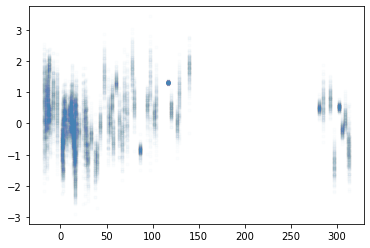

In [15]:
# diagnostics
ds = ztflc

for s in samples[np.random.randint(len(samples), size=200)]:
    master_offsets = s[len(gp.get_parameter_vector()):]
    offsets = offset_matrix.dot(master_offsets)
    gp.set_parameter_vector(s[0:len(gp.get_parameter_vector())])
    mu = gp.sample_conditional(y+offsets, ds['mjd'])
    diff = ds['mag'] - mu
    plt.errorbar(ds['mjd'] - const.sne_peak_mjd['g'], diff/ds['mag_err'], color="#4682b4", alpha=0.01, ls='', fmt='.')#), yerr=ds['mag_err'])

(-7.0, 7.0)

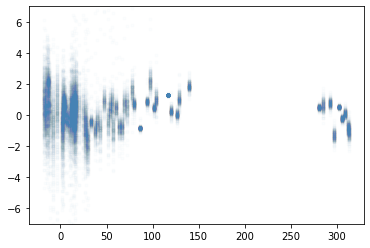

In [16]:
# alternative diagnostics.. not conditional but purely versus the mean model
ds = ztflc

for s in samples[np.random.randint(len(samples), size=200)]:
    master_offsets = s[len(gp.get_parameter_vector()):]
    offsets = offset_matrix.dot(master_offsets)
    gp.set_parameter_vector(s[0:len(gp.get_parameter_vector())])
    #mu = gp.sample_conditional(y+offsets, ds['mjd'])
    mu = gp.mean.get_value(ds['mjd'])
    diff = ds['mag'] - mu
    plt.errorbar(ds['mjd'] - const.sne_peak_mjd['g'], diff/ds['mag_err'], color="#4682b4", alpha=0.01, ls='', fmt='.')#), yerr=ds['mag_err'])
plt.ylim((-7,7))

-0.407134184756755
-0.4572291239478958


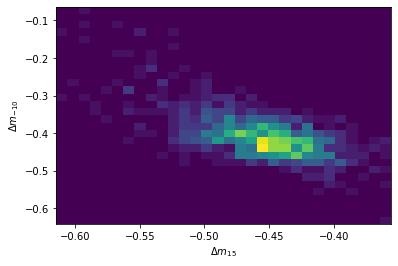

In [30]:
t_grid = np.linspace(const.sne_peak_mjd['g']-6, const.sne_peak_mjd['g']+12, 1000)
N = 1000
peak_times = np.empty(N)
m_peak = np.empty(N)
m_15 = np.empty(N)
m_n10 = np.empty(N)
# measure peak
for i,s in enumerate(samples[np.random.randint(len(samples), size=N)]):
    master_offsets = s[len(gp.get_parameter_vector()):]
    offsets = offset_matrix.dot(master_offsets)
    gp.set_parameter_vector(s[0:len(gp.get_parameter_vector())])
    #mu = gp.sample_conditional(y+offsets, t_min+0)
    
    mu = gp.mean.get_value(t_grid)
    i_peak = np.argmin(mu)
    t_peak = t_grid[i_peak]
    peak_times[i] = t_peak
    
    m_peak[i] = gp.sample_conditional(y, t_peak+0)
    m_15[i] = gp.sample_conditional(y, t_peak+15)
    m_n10[i] = gp.sample_conditional(y, t_peak-10)
#plt.hist(peak_times, bins=30);
#plt.axvline(const.sne_peak_mjd['g'])
idx = m_peak-m_n10 < 10
#plt.hist((m_peak-m_n10)[idx], bins=20, alpha=0.5, label=r'$\Delta m_{-10}$');
#plt.hist((m_peak-m_15), bins=20, alpha=0.5, label=r'$\Delta m_{15}$');
#plt.legend();
plt.hist2d((m_peak-m_15), (m_peak-m_n10)[idx], bins=30)
plt.ylabel(r'$\Delta m_{-10}$')
plt.xlabel(r'$\Delta m_{15}$')
print(np.mean((m_peak-m_n10)[idx]))
print(np.mean((m_peak-m_15)[idx]))

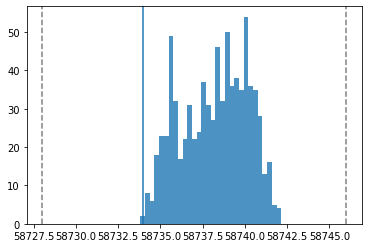

In [18]:
t_grid = np.linspace(const.sne_peak_mjd['g']-6, const.sne_peak_mjd['g']+12, 800)
N = 800
peak_times = np.empty(N)
# measure peak
for i,s in enumerate(samples[np.random.randint(len(samples), size=N)]):
    master_offsets = s[len(gp.get_parameter_vector()):]
    offsets = offset_matrix.dot(master_offsets)
    gp.set_parameter_vector(s[0:len(gp.get_parameter_vector())])
    
    mu = gp.sample_conditional(y+offsets, t_grid)
    i_peak = np.argmin(mu)
    t_peak = t_grid[i_peak]
    peak_times[i] = t_peak
plt.hist(peak_times, bins=30, alpha=0.8);
plt.axvline(const.sne_peak_mjd['g'])
plt.axvline(t_grid.min(), color='black', alpha=0.5, ls='--')
plt.axvline(t_grid.max(), color='black', alpha=0.5, ls='--')

In [19]:
np.percentile(peak_times, [16, 50, 84])
# r-band: array([58735.64900901, 58738.4954955 , 58740.2190991 ])

array([58735.74968711, 58738.47559449, 58740.28145181])